Row 47: No comment, sentiment score assigned: 0
Average Sentiment Score: -0.26340076824029285
An error occurred: FigureCanvasAgg.print_png() got an unexpected keyword argument 'overwrite'


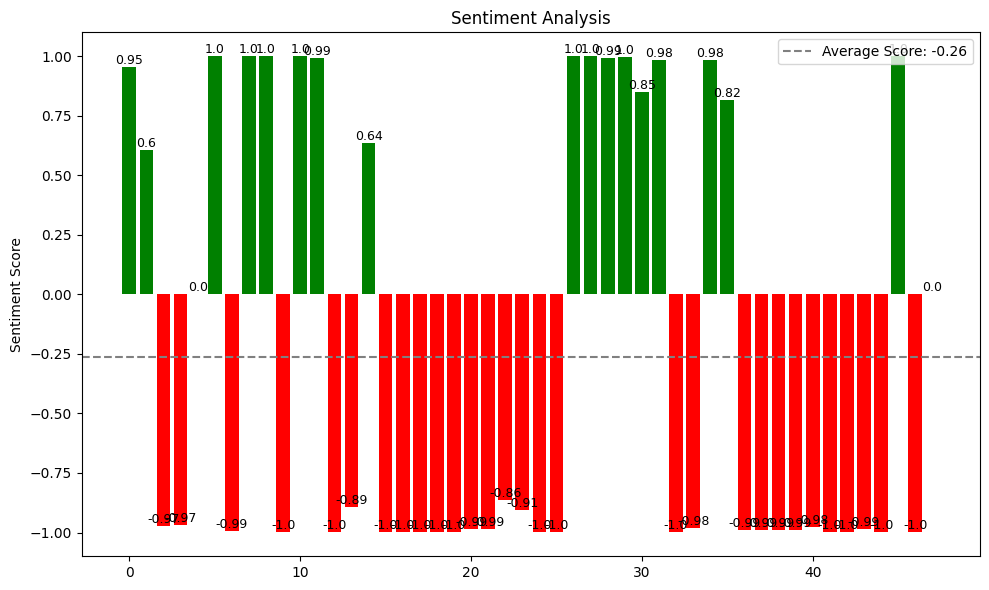

In [3]:
import torch
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import csv
from transformers import pipeline
import os

# Define the file path
file_path = "./data/wellbeing_survey.csv"

# Specify the model name DistilBERT model from Hugging Face fine-tuned on the Standford Sentiment Treebank v2 (SST-2) dataset
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

# Create the sentiment analysis pipeline with the specified model
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

try:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Check if the 'Sentiment Score' column exists, if not create it
    if 'Sentiment Score' not in df.columns:
        df['Sentiment Score'] = None

    # Empty list to accumulate sentiment scores
    new_sentiment_scores = []
    comments = []
    original_texts = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        if pd.isna(row['Sentiment Score']):  # Only analyze rows without a sentiment score
            if pd.isna(row['Comments']) or row['Comments'] == "":  # If the comment is blank
                score = 0  # Assign a score of zero
                print(f"Row {index}: No comment, sentiment score assigned: {score}")
            else:
                data = row['Comments']
                results = sentiment_pipeline(data)  # Apply sentiment analysis
                score = results[0]['score'] if results[0]['label'] == 'POSITIVE' else -results[0]['score']
                print(f"Row {index}: Comment: {row['Comments']}, Sentiment score: {score}")

            # Update the DataFrame with the sentiment score
            df.at[index, 'Sentiment Score'] = score
            new_sentiment_scores.append(score)
            comments.append(row['Comments'])
            original_texts.append(data)
        else:
            # Existing scores should also be included in the plotting data
            score = row['Sentiment Score']
            new_sentiment_scores.append(score)
            comments.append(row['Comments'])
            original_texts.append(row['Comments'])

    # Save the updated DataFrame back to the CSV file
    df.to_csv(file_path, index=False)

    # Calculate the average sentiment score for all scores
    all_scores = df['Sentiment Score'].tolist()
    if all_scores:
        average_score = sum(all_scores) / len(all_scores)
        print(f"Average Sentiment Score: {average_score}")
    else:
        print("No comments to analyze for sentiment.")

    # Create a DataFrame to store the sentiment scores and optional comments
    df_sentiment = pd.DataFrame({'Sentiment Score': all_scores, 'Comment': comments, 'Text': original_texts})

    # Create bar chart with colored bars based on sentiment score
    colors = ['green' if score >= 0 else 'red' for score in df_sentiment['Sentiment Score']]
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df_sentiment.index, df_sentiment['Sentiment Score'], color=colors)

    # Add labels, title, and axis labels
    plt.title('Sentiment Analysis')
    plt.ylabel('Sentiment Score')

    # Add value labels on top of the bars
    for bar, score in zip(bars, df_sentiment['Sentiment Score']):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{round(score, 2)}',
                 ha='center', va='bottom', fontsize=9)

    # Add horizontal line for average sentiment score
    plt.axhline(y=average_score, color='gray', linestyle='--', label=f'Average Score: {round(average_score, 2)}')

    plt.legend()  # Show legend with average score
    plt.tight_layout()

    # Save the plot as a PNG file in the 'static' folder
    static_folder = 'static'
    if not os.path.exists(static_folder):
        os.makedirs(static_folder)
    
    plt.savefig(f'{static_folder}/sentiment_analysis_plot.png', overwrite=True)

    # Display the plot
    plt.show()

except FileNotFoundError:
    print(f"Error: The file at {file_path} was not found.")  # In case file is not found at the path
except Exception as e:
    print(f"An error occurred: {e}")  # Catch other errors